## Workplace Contact Data Set 

In [188]:
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib
matplotlib.use('Agg')
%matplotlib inline

/Users/Jeremyd/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [189]:
# Read in Contacts Data
contacts = pd.read_csv("../data/contacts.csv", header = None)

# Read in Department Data
department = pd.read_csv("../data/department.csv", header = None)

**Contact Data**
* number of rows = 9827
    * 9827 f-f interactions
* number of columns = 3
    * time
    * id of p1
    * id of p2

In [190]:
# dim stores [num rows, num cols]
c_dimension = contacts.shape
c_num_rows = c_dimension[0]
c_num_cols = c_dimension[1]
c_dimension

(9827, 3)

**Department Data**
* number of rows = 92
    * 92 employees
* number of columns = 2
    * id
    * department

In [191]:
d_dimension = department.shape
d_num_rows = d_dimension[0]
d_num_cols = d_dimension[1]
d_dimension

(92, 2)

**Cleaning the Data**  
* Need to modify time column to start from 0

In [192]:
# fixes time
def reduce_time(t):
    return t - 28800

In [193]:
contacts[0] = contacts[0].apply(reduce_time)

**Combine Data Sets - Contacts + Department**

* Use Department Data Frame to build a map 

In [194]:
map_id_dep = {}
for i in range(d_num_rows):
    map_id_dep[department.iloc[i, 0]] = department.iloc[i, 1]

* Define a function that adds departments to a df

In [195]:
def add_department(people, name, df, map):
    '''
    people: series of people's id
    name: string for name of the column
    df: dataframe
    map: map of id to department
    '''
    dep = []
    for ind in people:
        ind_dep = map.get(ind, -1)
        dep.append(ind_dep)
    
    df[name] = np.array(dep)

In [196]:
p1 = contacts[1] 
n1 = "p1 department"
add_department(p1, n1, contacts, map_id_dep)

contacts.head()

,0,1,2,p1 department
0,20,492,938,SRH
1,60,267,272,DSE
2,500,181,826,DSE
3,980,79,181,DSE
4,1200,150,196,SRH


In [197]:
p2 = contacts[2]
n2 = "p2 department"
add_department(p2, n2, contacts, map_id_dep)

contacts.head()

,0,1,2,p1 department,p2 department
0,20,492,938,SRH,DMCT
1,60,267,272,DSE,DSE
2,500,181,826,DSE,DISQ
3,980,79,181,DSE,DSE
4,1200,150,196,SRH,DSE


### Contacts - Cleaned and Modified DF

In [198]:
contacts = contacts.rename(index = str, columns = {0 : "time", 1 : "p1", 2 : "p2"})
contacts.head()

,time,p1,p2,p1 department,p2 department
0,20,492,938,SRH,DMCT
1,60,267,272,DSE,DSE
2,500,181,826,DSE,DISQ
3,980,79,181,DSE,DSE
4,1200,150,196,SRH,DSE


### graph_id - networkx graph (nodes = id)

In [199]:
graph_id = nx.from_pandas_dataframe(contacts, "p1", "p2", "time")


In [200]:
graph_id.nodes()

NodeView((492, 938, 267, 272, 181, 826, 79, 150, 196, 21, 205, 448, 765, 39, 253, 80, 123, 845, 118, 311, 95, 771, 153, 164, 179, 481, 122, 120, 819, 431, 778, 271, 601, 15, 56, 194, 786, 603, 496, 275, 222, 50, 172, 29, 223, 116, 285, 762, 63, 939, 335, 105, 113, 513, 119, 154, 494, 48, 209, 17, 66, 102, 134, 240, 242, 804, 511, 875, 184, 499, 268, 185, 533, 987, 210, 35, 131, 211, 751, 265, 784, 273, 662, 709, 101, 779, 132, 255, 213, 791, 743, 87))

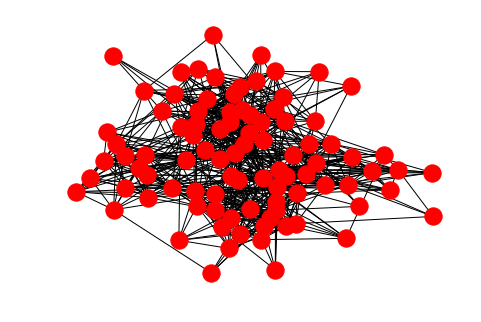

In [201]:
nx.draw(graph_id)

Edges in a Graph represent at least 1 face to face interaction between employees

In [217]:
list(graph_id.neighbors(35))

[210, 845, 826, 804, 273, 253, 265, 268, 185, 778, 743, 255]

Employee 35 interacted with 12 unique people

In [216]:
test = contacts[contacts["p1"] == 35]
test.p2.unique()

array([210, 845, 826, 804, 273, 253, 265, 268, 185, 778, 743, 255])

In [ ]:
Employee 35 had a total interaction of 48 interactions

In [220]:
x[35]
# y[35] there is no 35 in the p2 column 

48

**Characteristics of the Network**

Network consists of 1 Giant Connected Component

In [234]:
nx.number_connected_components(graph_id)

1

Average Degree = 16.4

In [222]:
# Average Degree
graph_id_avg_degree = (2.0 * graph_id.number_of_edges())/graph_id.number_of_nodes()
graph_id_avg_degree

16.41304347826087

On Average, an employee interacts with approximately 18% of the other employees

In [229]:
graph_id_avg_degree / d_num_rows

0.17840264650283555

<Container object of 28 artists>

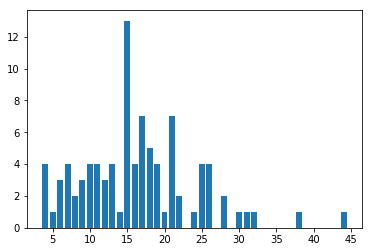

In [284]:
degrees = []
for node in department[0]:
    degrees.append(graph_id.degree(node))

degrees = pd.Series(degrees).value_counts()

d = degrees.index.values # get degrees
count = degrees.values # get counts

# Degree Distribution
plt.bar(d, count)

**Average # of Interactions Per Person**
* avg = 213.63
    * while each person doesn't interact with a lot of other unique people, they interact a lot with the same people over and over again
* avg # of interactions per day = 19.42 (assuming 11 days)

In [334]:
interactions = {}

p1_count = contacts["p1"].value_counts() # holds counts for p1
p2_count = contacts["p2"].value_counts() # holds counts for p2

for node in department[0]:
    interactions[node] = p1_count.get(node, 0) + p2_count.get(node, 0)

avg_interactions = np.mean(list(interactions.values())) # average # of interactions
avg_interactions

213.63043478260869

**Path Characteristics**

In [336]:
nx.average_shortest_path_length(graph_id)

1.964405160057334

In [337]:
nx.diameter(graph_id)

3

In [338]:
nx.radius(graph_id)

2

**Analysis of Inter-department and Intra-department interactions**

In [351]:
graph_dept = nx.from_pandas_dataframe(contacts, "p1 department", "p2 department", create_using =  nx.MultiGraph())

* 82% of contacts are within one's own department
* 18% of contacts are outside of one's own department

In [377]:
sum(contacts["p1 department"] == contacts["p2 department"]) / c_num_rows

0.82029103490383637

**Finding # of Interactions**

In [439]:
# finds the number of contacts between 2 departments
def num_contacts(dept1, dept2, df, col1, col2):
    data = df[((df[col1] == dept1) & (df[col2] == dept2)) | ((df[col1] == dept2) & (df[col2] == dept1))]
    return data.shape[0]

* inter_dept_interactions is a dict mapping departments to an array storing the # of interactions between itself and other departments
    * array indices are recorded as follows
        * 0 - num of interactions w/ **DISQ**
        * 1 - num of interactions w/ **DSE**
        * 2 - num of interactions w/ **SFLE**
        * 3 - num of interactions w/ **DMCT**
        * 4 - num of interactions w/ **SRH**

In [441]:
departments = department[1].unique() # unique departments
inter_dept_interactions = {} # dict

for i in range(len(departments)):
    dept1 = departments[i]
    # print("dept1: {}".format(dept1))
    dept_contacts = []
    for j in range(len(departments)):
        dept2 = departments[j]
        # print("dept2: {}".format(dept2))
        dept_contacts.append(num_contacts(dept1, dept2, contacts, "p1 department", "p2 department"))
        # print(dept_contacts)
    inter_dept_interactions[dept1] = dept_contacts
    
inter_dept_interactions

{'DISQ': [1194, 467, 58, 333, 27],
 'DMCT': [333, 523, 21, 1435, 141],
 'DSE': [467, 2820, 30, 523, 106],
 'SFLE': [58, 30, 36, 21, 60],
 'SRH': [27, 106, 60, 141, 2576]}